In [ ]:
from datetime import date
from jugaad_data.nse import stock_df

# Define the stock symbol and date range
symbol = "RELIANCE"
start_date = date(2023, 1, 1)
end_date = date(2023, 12, 31)

# Fetch the historical data
df = stock_df(symbol=symbol, from_date=start_date, to_date=end_date, series="EQ")

# Display the data
print(df)

          DATE SERIES     OPEN     HIGH      LOW  PREV. CLOSE      LTP  \
0   2023-12-29     EQ  2611.10  2614.00  2579.30      2605.55  2587.00   
1   2023-12-28     EQ  2589.80  2612.00  2586.85      2586.85  2605.00   
2   2023-12-27     EQ  2582.00  2599.90  2573.10      2578.05  2583.35   
3   2023-12-26     EQ  2568.00  2591.95  2562.70      2565.05  2579.00   
4   2023-12-22     EQ  2559.60  2580.90  2547.65      2562.55  2561.00   
..         ...    ...      ...      ...      ...          ...      ...   
241 2023-01-06     EQ  2526.65  2547.95  2518.30      2514.05  2537.00   
242 2023-01-05     EQ  2523.50  2536.40  2504.00      2518.55  2521.80   
243 2023-01-04     EQ  2557.00  2561.05  2514.00      2557.05  2516.65   
244 2023-01-03     EQ  2565.05  2573.00  2547.80      2575.90  2555.80   
245 2023-01-02     EQ  2550.00  2579.00  2548.20      2547.20  2577.90   

       CLOSE     VWAP    52W H   52W L   VOLUME         VALUE  NO OF TRADES  \
0    2584.95  2589.61  2630.95  

In [ ]:
!pip install jugaad_data

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.8/115.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.1.8
    Uninstalling click-8.1.8:
      Successfully uninstalled click-8.1.8
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.12.3
    Uninstalling beautifulsoup4-4.12.3:
      Successfully uninstalled beautifulsoup4-4.12.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2024.10.0 requires click>=8.1, but you have click 7.1.2 which is incompatible.
flask 3.1.0 requires click>=8.1.3, but you have click 7.1.2 which is incompatible.
typer 0.15.1 requires click>=8.0.0, but you have click 7.1.2 which is incompatible.
yfinance 0.2.51 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# define a function to create bollinger bands
def add_bollinger_bands(data, window=20, num_std_dev=2):
    rolling_mean = data['CLOSE'].rolling(window=window).mean() # simple moving average SMA
    rolling_std = data['CLOSE'].rolling(window=window).std()
    data['upper_band'] = rolling_mean + (rolling_std * num_std_dev)
    data['lower_band'] = rolling_mean - (rolling_std * num_std_dev)
    return data

In [ ]:
# define a function to create and get the Relative Strength Index (RSI)
def RSI(data, window=13):
    delta = data['CLOSE'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    av_gain = gain.rolling(window=window).mean()
    av_loss = loss.rolling(window=window).mean()
    rs = av_gain / av_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    data['Overbought'] = 70
    data['Oversold'] = 30
    return data

In [ ]:
# define a function to create and et the trading strategy
# buy when the RSI is less than 30
# sell when RSI is greater than 60

def strategy(data):
  position = 0
  buy_price = []
  sell_price = []
  for i in range(len(data)):
    if data['CLOSE'][i] < data['lower_band'][i] and data['RSI'][i] < data['Oversold'][i] and position == 0:
      position = 1
      buy_price.append(data['CLOSE'][i])
      sell_price.append(np.nan)
    elif data['CLOSE'][i] > data['upper_band'][i] and data['RSI'][i] > data['Overbought'][i] and position == 1:
      position = 0
      sell_price.append(data['CLOSE'][i])
      buy_price.append(np.nan)
    else:
      buy_price.append(np.nan)
      sell_price.append(np.nan)
  return buy_price, sell_price

In [ ]:
data = add_bollinger_bands(df)
data = RSI(data)
print(data.columns)

Index(['DATE', 'SERIES', 'OPEN', 'HIGH', 'LOW', 'PREV. CLOSE', 'LTP', 'CLOSE',
       'VWAP', '52W H', '52W L', 'VOLUME', 'VALUE', 'NO OF TRADES', 'SYMBOL',
       'Volume_Oscillator', 'upper_band', 'lower_band', 'RSI', 'Overbought',
       'Oversold'],
      dtype='object')


In [ ]:
buy_price, sell_price = strategy(data)
data['Buy Price'] = buy_price
data['Sell Price'] = sell_price

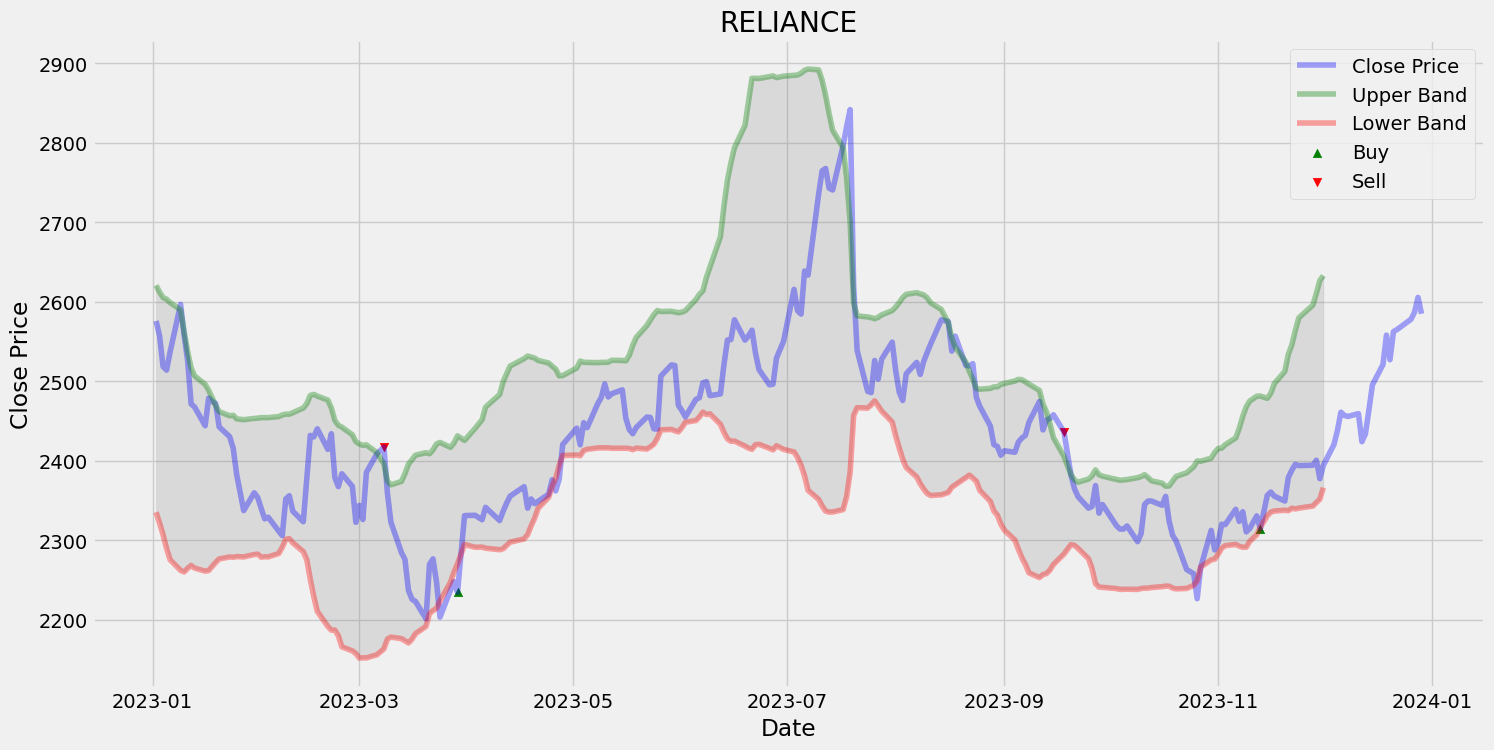

In [ ]:
# plot the close price
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('RELIANCE')
plt.xlabel('Date')
plt.ylabel('Close Price')
ax.plot(data['DATE'], data['CLOSE'], label='Close Price', alpha=0.35, color='blue')
ax.plot(data['DATE'], data['upper_band'], label='Upper Band', alpha=0.35, color='green')
ax.plot(data['DATE'], data['lower_band'], label='Lower Band', alpha=0.35, color='red')
ax.fill_between(data['DATE'], data['upper_band'], data['lower_band'], color='grey', alpha=0.2)
ax.scatter(data['DATE'], data['Buy Price'], label='Buy', marker='^', color='green')
ax.scatter(data['DATE'], data['Sell Price'], label='Sell', marker='v', color='red')
plt.legend(loc='best')

In [ ]:
df.columns

Index(['DATE', 'SERIES', 'OPEN', 'HIGH', 'LOW', 'PREV. CLOSE', 'LTP', 'CLOSE',
       'VWAP', '52W H', '52W L', 'VOLUME', 'VALUE', 'NO OF TRADES', 'SYMBOL',
       'Volume_Oscillator', 'upper_band', 'lower_band', 'RSI', 'Overbought',
       'Oversold', 'Buy Price', 'Sell Price'],
      dtype='object')

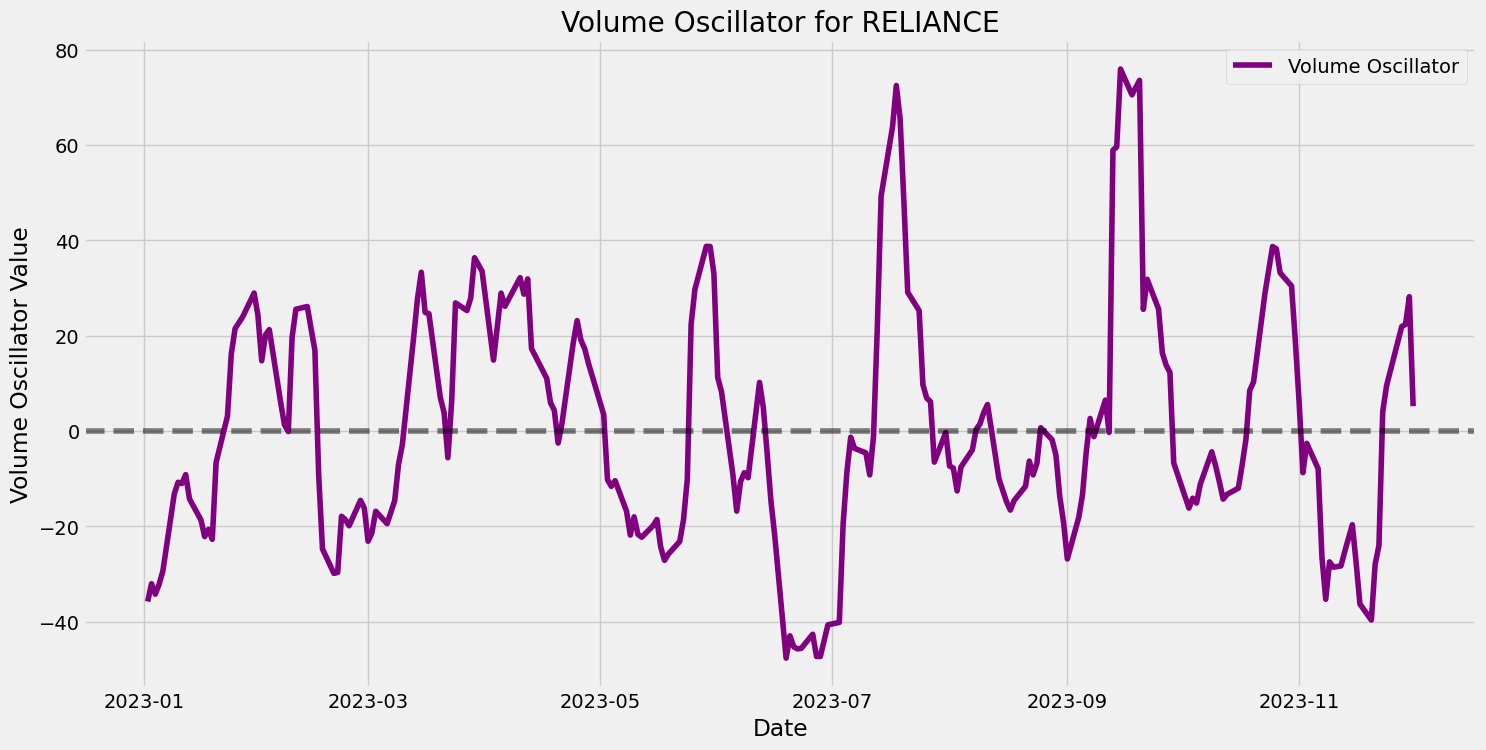

In [ ]:
# prompt: code volume oscillator for above ticker

import pandas as pd
import numpy as np

def volume_oscillator(data, short_period=5, long_period=20):
    """
    Calculates the Volume Oscillator.

    Args:
        data (pd.DataFrame): DataFrame with 'Volume' column.
        short_period (int): Short-term moving average period.
        long_period (int): Long-term moving average period.

    Returns:
        pd.Series: Volume Oscillator values.
    """

    # Calculate short-term and long-term moving averages of volume
    short_ma = data['VOLUME'].rolling(window=short_period).mean()
    long_ma = data['VOLUME'].rolling(window=long_period).mean()

    # Calculate the Volume Oscillator
    volume_osc = 100 * ((short_ma - long_ma) / long_ma)

    return volume_osc


# Assuming 'df' is your DataFrame with 'Volume' and 'DATE' columns from the previous code
df['Volume_Oscillator'] = volume_oscillator(df)

# Plot the Volume Oscillator
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df['DATE'], df['Volume_Oscillator'], label='Volume Oscillator', color='purple')
ax.axhline(0, color='black', linestyle='--', alpha=0.5)  # Add a zero line for reference
plt.title('Volume Oscillator for RELIANCE')
plt.xlabel('Date')
plt.ylabel('Volume Oscillator Value')
plt.legend()
plt.show()

Rate of Change of Volume at index 100: -34.27%


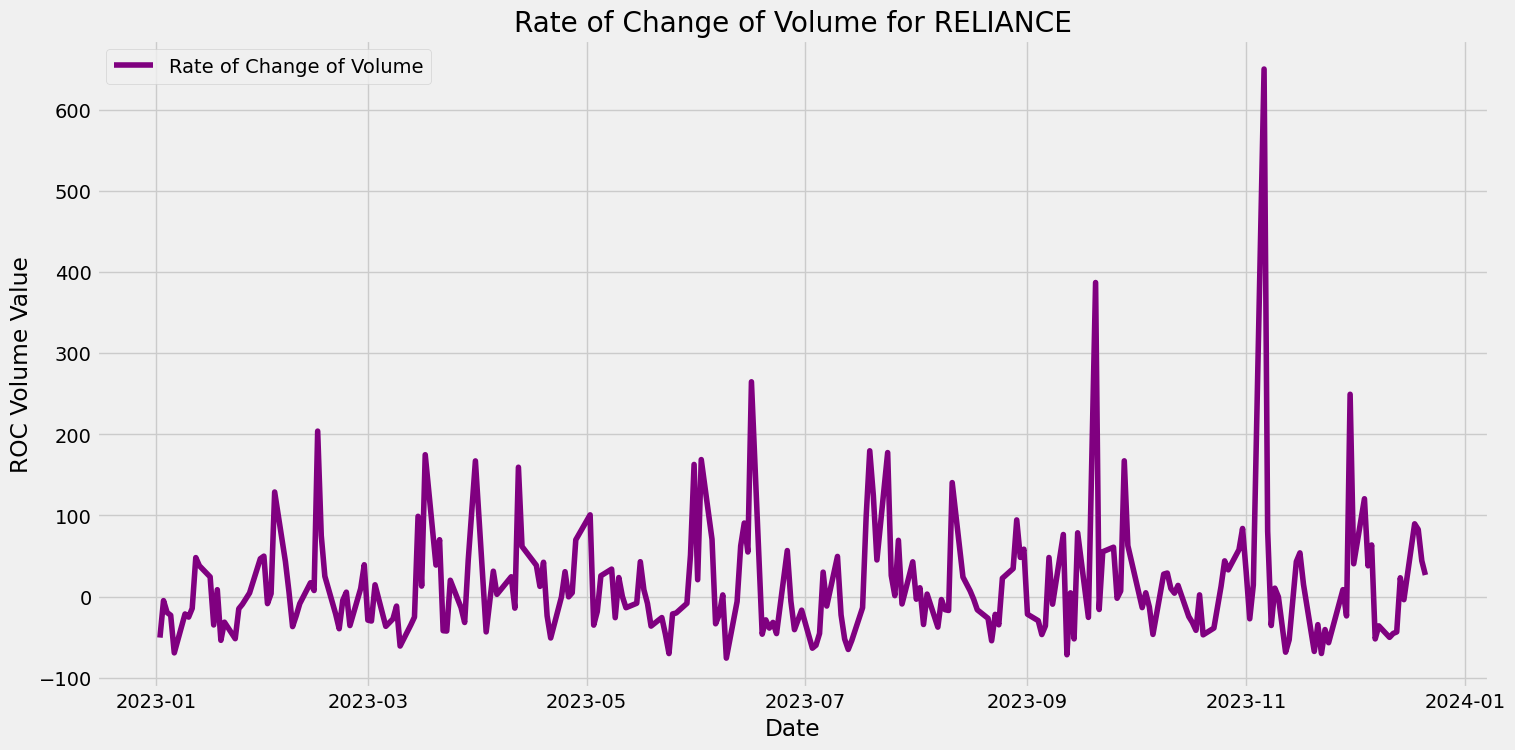

In [ ]:
# prompt: can you generate a function to see RATE OF CHANGE OF VOLUME AT A POINT

def rate_of_change_volume(data, point_index, window=5):
    """
    Calculates the rate of change of volume at a specific point.

    Args:
        data (pd.DataFrame): DataFrame with 'VOLUME' and 'DATE' columns.
        point_index (int): Index of the point in the DataFrame.
        window (int): The number of preceding periods to consider for the calculation.

    Returns:
        float: Rate of change of volume at the specified point. Returns np.nan if the calculation is not possible.
    """
    if point_index < window:
        return np.nan  # Not enough data points to calculate rate of change

    current_volume = data['VOLUME'].iloc[point_index]
    past_volume = data['VOLUME'].iloc[point_index - window]

    roc = ((current_volume - past_volume) / past_volume) * 100

    return roc

# Example usage (assuming 'df' is your DataFrame and you want the ROC at index 100):
# Replace 100 with the actual index of the point you're interested in
point_index = 100
roc_at_point = rate_of_change_volume(df, point_index)

print(f"Rate of Change of Volume at index {point_index}: {roc_at_point:.2f}%")


#To plot the rate of change over time:
roc_values = []
for i in range(len(df)):
    roc_values.append(rate_of_change_volume(df,i))

df['ROC_Volume'] = roc_values

#Plot
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df['DATE'], df['ROC_Volume'], label='Rate of Change of Volume', color='purple')
plt.title('Rate of Change of Volume for RELIANCE')
plt.xlabel('Date')
plt.ylabel('ROC Volume Value')
plt.legend()
plt.show()

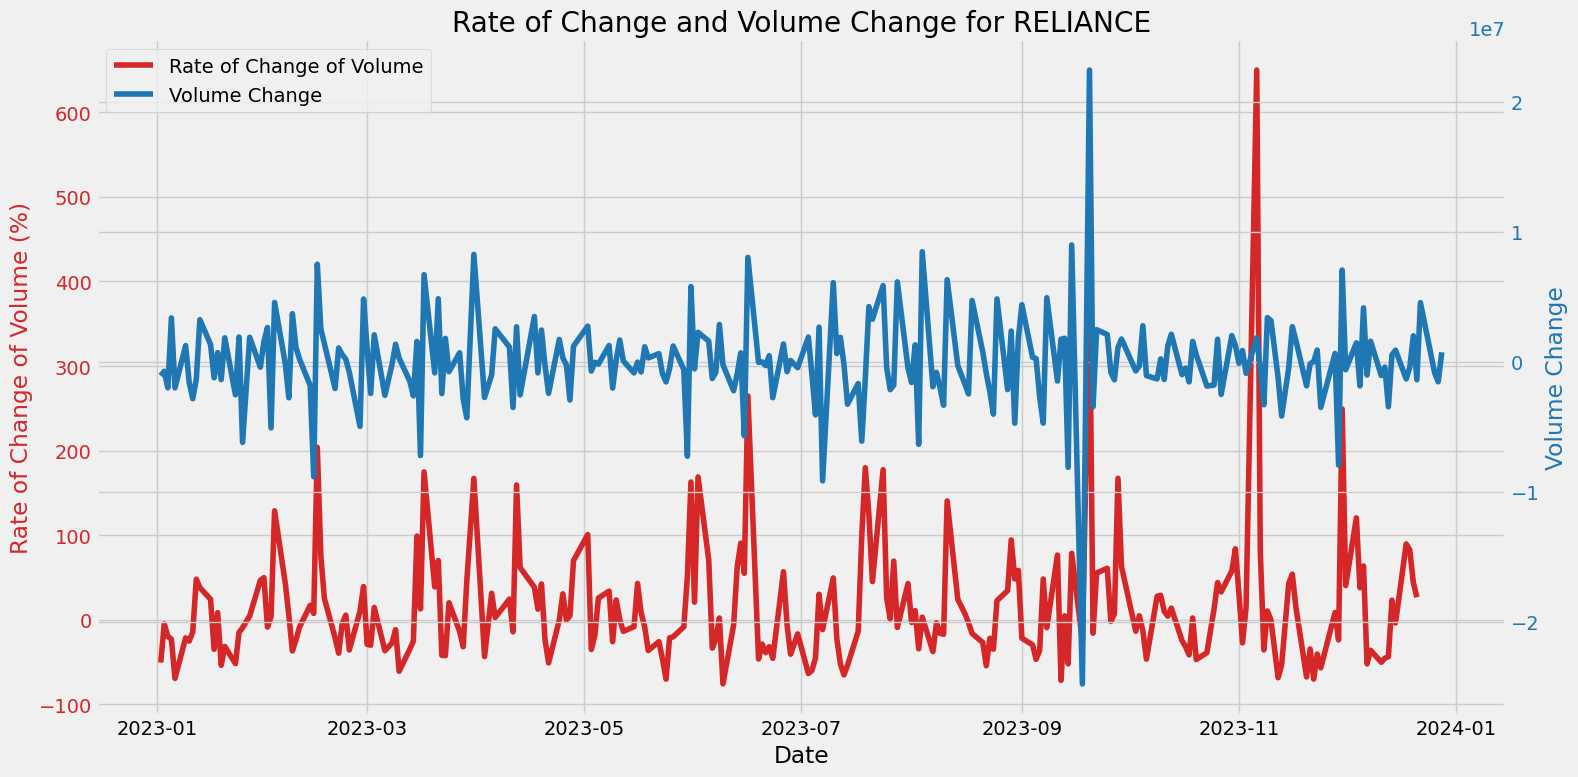

In [ ]:
# prompt: GENERATE BOTH RATE OF CHANGE OF VOLUME AND VOLUME CHANGE IN SINGLE PLOT

import matplotlib.pyplot as plt

# ... (Your existing code) ...

# Calculate volume change
df['Volume_Change'] = df['VOLUME'].diff()

# Plotting both Rate of Change and Volume Change in a single plot
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot Rate of Change of Volume
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Rate of Change of Volume (%)', color=color)
ax1.plot(df['DATE'], df['ROC_Volume'], color=color, label='Rate of Change of Volume')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for Volume Change
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Volume Change', color=color)
ax2.plot(df['DATE'], df['Volume_Change'], color=color, label='Volume Change')
ax2.tick_params(axis='y', labelcolor=color)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Rate of Change and Volume Change for RELIANCE')
fig.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

In [ ]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

SCRIP = 'RELIANCE'
link = f'https://www.screener.in/company/{SCRIP}'
hdr = {'User-Agent':'Mozilla/5.0'}
req = Request(link,headers=hdr)

try:
    page=urlopen(req)
    soup = BeautifulSoup(page)

    div_html = soup.find('div',{'class': 'company-ratios'})
    ul_html = div_html.find('ul',{'id': 'top-ratios'})
    market_cap = 0.0

    # market_fundamentals = ["Market Cap","Current Price","High / Low", "Stock P/E","Book Value","Dividend Yield","ROCE","ROE","Face Value"]
    # for name in market_fundamentals:

    for li in ul_html.find_all("li"):
      name_span = li.find('span',{'class':'name'})

      if "Market Cap" in name_span.text:
          num_span = li.find('span',{'class':'number'})
          num_span = num_span.text.replace(',', '')
          market_cap = float(num_span) if (num_span != '') else 0.0
          break

    print(f'Market Cap {market_cap} Cr')

except:
    print(f'EXCEPTION THROWN: UNABLE TO FETCH DATA FOR {SCRIP}')


Market Cap 1756569.0 Cr


In [ ]:
ret = extract_screener_data('RELIANCE')

Market Cap : [1726730.0] 
Current Price : [1276.0] 
High / Low : [1609.0, 1202.0] 
Stock P/E : [48.9] 
Book Value : [387.0] 
Dividend Yield : [0.38] 
ROCE : [9.6] 
ROE : [8.42] 
Face Value : [10.0] 
Table not found in peers section.
Quarters Data:
                       Dec 2021 Mar 2022 Jun 2022 Sep 2022 Dec 2022 Mar 2023  \
0             Sales +  111,152  129,479  146,478  137,346  125,849  129,674   
1          Expenses +   97,257  114,898  125,525  125,561  110,950  110,542   
2    Operating Profit   13,895   14,581   20,953   11,785   14,899   19,132   
3               OPM %      12%      11%      14%       9%      12%      15%   
4      Other Income +    3,443    3,072    3,399    3,499    2,689    2,750   
5            Interest    2,301    1,984    2,616    2,916    3,349    3,752   
6        Depreciation    2,597    2,465    2,248    2,611    2,529    3,779   
7   Profit before tax   12,440   13,204   19,488    9,757   11,710   14,351   
8               Tax %      18%      16% 

In [ ]:
for df in ret:
  print(df.columns)

Index(['', 'Mar 2022', 'Jun 2022', 'Sep 2022', 'Dec 2022', 'Mar 2023',
       'Jun 2023', 'Sep 2023', 'Dec 2023', 'Mar 2024', 'Jun 2024', 'Sep 2024',
       'Oct 2024'],
      dtype='object')
Index(['', 'Mar 2013', 'Mar 2014', 'Mar 2015', 'Mar 2016', 'Mar 2017',
       'Mar 2018', 'Mar 2019', 'Mar 2020', 'Mar 2021', 'Mar 2022', 'Mar 2023',
       'Mar 2024'],
      dtype='object')
Index(['', 'Mar 2013', 'Mar 2014', 'Mar 2015', 'Mar 2016', 'Mar 2017',
       'Mar 2018', 'Mar 2019', 'Mar 2020', 'Mar 2021', 'Mar 2022', 'Mar 2023',
       'Mar 2024', 'Sep 2024'],
      dtype='object')
Index(['', 'Mar 2013', 'Mar 2014', 'Mar 2015', 'Mar 2016', 'Mar 2017',
       'Mar 2018', 'Mar 2019', 'Mar 2020', 'Mar 2021', 'Mar 2022', 'Mar 2023',
       'Mar 2024'],
      dtype='object')
Index(['', 'Dec 2021', 'Mar 2022', 'Jun 2022', 'Sep 2022', 'Dec 2022',
       'Mar 2023', 'Jun 2023', 'Sep 2023', 'Dec 2023', 'Mar 2024', 'Jun 2024',
       'Sep 2024', 'Dec 2024'],
      dtype='object')


In [ ]:
# prompt: do data analysis for the dataframes in ret variable

# Assuming 'ret' is a tuple of pandas DataFrames as returned by extract_screener_data
for df in ret:
    if df is not None:  # Check if the DataFrame is not None
        print(df.head())  # Display the first few rows
        print(df.info())   # Display data types and non-null values
        print(df.describe()) # Display descriptive statistics
        # Add more analysis here as needed, such as:
        # - Correlation analysis: df.corr()
        # - Handling missing values: df.fillna(), df.dropna()
        # - Data visualization: df.plot(), import matplotlib.pyplot as plt, etc.
        # - Specific column analysis: df['column_name'].value_counts(), df['column_name'].mean(), etc.
    else:
        print("DataFrame is None. No data to analyze.")

                Mar 2022 Jun 2022 Sep 2022 Dec 2022 Mar 2023 Jun 2023  \
0   Promoters +   50.66%   50.62%   50.56%   50.49%   50.41%   50.39%   
1        FIIs +   24.23%   23.90%   23.58%   23.48%   22.49%   22.55%   
2        DIIs +   14.23%   14.67%   14.91%   15.26%   16.06%   16.13%   
3  Government +    0.17%    0.17%    0.16%    0.16%    0.16%    0.17%   
4      Public +   10.71%   10.64%   10.78%   10.59%   10.89%   10.76%   

  Sep 2023 Dec 2023 Mar 2024 Jun 2024 Sep 2024 Oct 2024  
0   50.27%   50.30%   50.31%   50.33%   50.24%   50.24%  
1   22.60%   22.13%   22.06%   21.75%   21.30%   20.17%  
2   15.99%   16.59%   16.98%   17.30%   17.61%   18.24%  
3    0.17%    0.18%    0.19%    0.19%    0.19%    0.18%  
4   10.98%   10.80%   10.46%   10.43%   10.67%   11.18%  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0             6 non-null      objec